In [93]:
import os
import numpy as np
os.chdir('/import/home2/yhchenmath/Code/ucs/')
# No warning
import warnings
import tifffile
import h5py
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn
warnings.filterwarnings('ignore')
from downstream.utils import read_json_to_namespace

config = read_json_to_namespace("./downstream/config/xenium_breast_cancer.json")

# Mask
method_list = ["UCS_Cellpose", "UCS_10X", "UCS SM+Marker",  "BIDCell", "Nuclei_Cellpose", "Cell_10X", "Nuclei_10X", "Baysor"]

In [82]:
mask_dict = {}
df_dict = {}
ad_st_dict = {}
boundary_dict = {}
for method in method_list:
    mask = tifffile.imread(config.segmentation_results[method])
    df = pd.read_csv(os.path.join(config.output_dir, f"{method}_cell_feature.csv"), index_col=0)
    ad_st = sc.read_h5ad(f"{config.output_dir}/scVI_output/{method}/annotated_adata_st.h5ad")
    mask_dict[method] = mask
    boundary_dict[method] = find_boundaries(mask, mode='inner')
    df_dict[method] = df
    ad_st_dict[method] = ad_st

In [83]:
# Load other
he = tifffile.imread(config.he)
dapi = tifffile.imread(config.dapi)

gene_map = tifffile.imread(config.gene_map)
gene_map_sum = gene_map.sum(axis=2)
with open(config.gene_names, 'r') as f:
    gene_names = f.readlines()
gene_names = [x.strip() for x in gene_names]

## Annotation Result

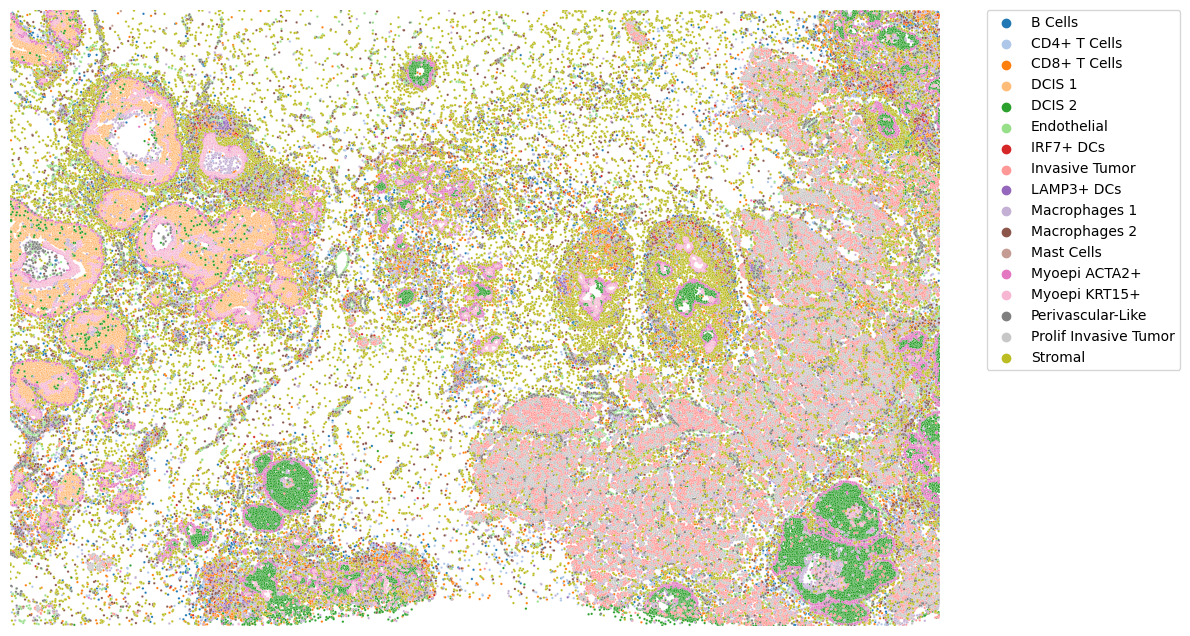

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
# reset style
plt.style.use('default')
plt.figure(figsize=(12, 8))
plt.ylim(0, mask.shape[0])
plt.xlim(mask.shape[1], 0)
# Sorted by cell type
annotated_adata_st = ad_st_dict["UCS_10X"]
plot_df = pd.DataFrame(annotated_adata_st.obsm['spatial'], columns=['center_x', 'center_y'])
plot_df['C_scANVI'] = annotated_adata_st.obs['C_scANVI'].values
plot_df = plot_df.sort_values(by='C_scANVI')
# Selected Endothelial and invasive Tumor / Prolif Invasive Tumor
# plot_df = plot_df[plot_df['C_scANVI'].isin(["DCIS 1", "DCIS 2", "Invasive Tumor", "Prolif Invasive Tumor", "T Cell & Tumor Hybrid", "Myoepi ACTA2+", "Myoepi KRT15+"])]
# Change color
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=3 , palette='tab20')
# Legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# No axis
plt.axis('off')
plt.show()

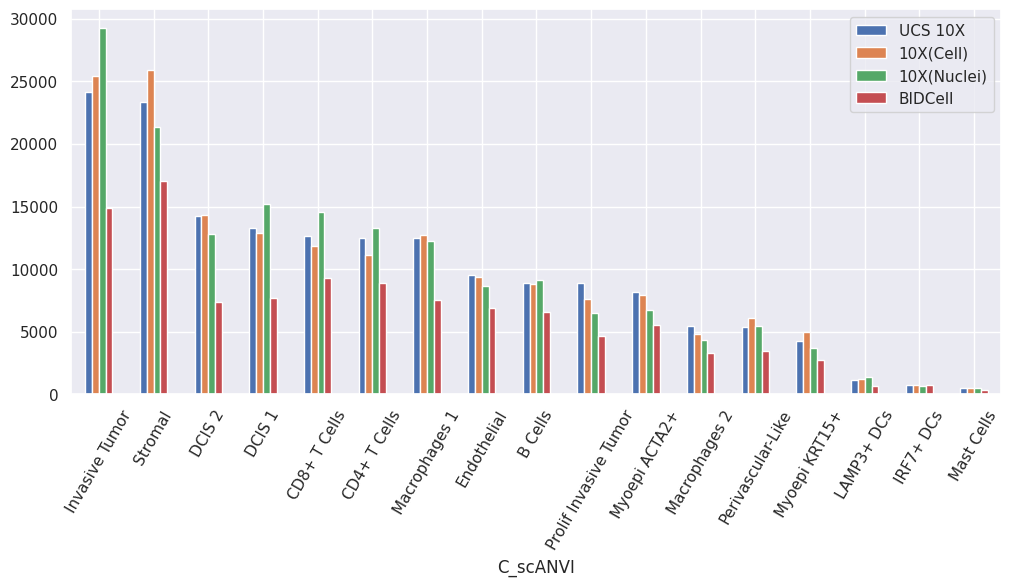

In [86]:
# Cell type distribution
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 5))
bar_list = []
for method in ["UCS_10X", "Cell_10X", "Nuclei_10X", "BIDCell"]:
    bar_list.append(ad_st_dict[method].obs["C_scANVI"].value_counts())

bar_df = pd.concat(bar_list, axis=1)
bar_df.columns = ["UCS 10X", "10X(Cell)", "10X(Nuclei)", "BIDCell"]
# Plot
bar_df.plot(kind="bar", legend=[1,1,1,1], title=False, ax=ax)
# Rotate x label
plt.xticks(rotation=60)
# No title
plt.show()

## Load positive marker

In [87]:
pos_gene_df = pd.read_csv(config.pos_gene_csv, index_col=0)

## An annotation Result ROI

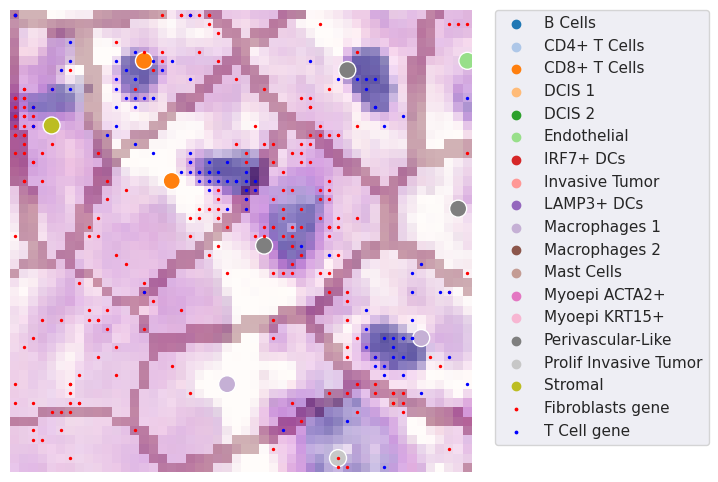

In [88]:
fig, ax = plt.subplots(figsize=(6, 6))
# Sorted by cell type
x_min, x_max, y_min, y_max = 2050, 2100, 2025, 2075
ad = ad_st_dict["Cell_10X"]
cell_roi = ad[(ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (ad.obsm["spatial"][:, 1] < y_max)]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=150 , palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
np.random.seed(5)
pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
for i in range(0, gene_map.shape[2]):
    if pos_gene[i] > 0:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="red")
pos_gene = pos_gene_df.loc['CD4Tconv/Treg'].astype(bool) | pos_gene_df.loc['CD8T/CD8Tex'].astype(bool)
for i in range(0, gene_map.shape[2]):
    if pos_gene[i] > 0:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
# Legend outside
ax.scatter(0, 0, s=3, c="red", label="Fibroblasts gene")
ax.scatter(0, 0, s=3, c="blue", label="T Cell gene")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.set_axis_off()
ax.imshow(boundary_dict['Cell_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)

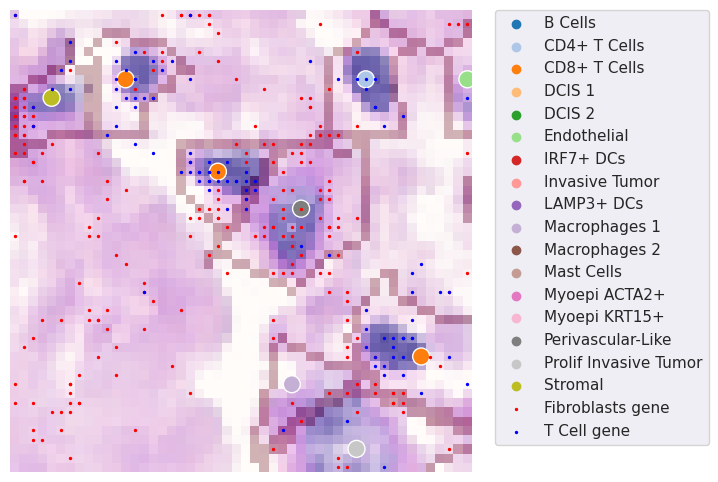

In [89]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))
# Sorted by cell type
x_min, x_max, y_min, y_max = 2050, 2100, 2025, 2075
ad = ad_st_dict["UCS_10X"]
cell_roi = ad[(ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (ad.obsm["spatial"][:, 1] < y_max)]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=150 , palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
np.random.seed(5)
pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
for i in range(0, gene_map.shape[2]):
    if pos_gene[i] > 0:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="red")
pos_gene = pos_gene_df.loc['CD4Tconv/Treg'].astype(bool) | pos_gene_df.loc['CD8T/CD8Tex'].astype(bool)
for i in range(0, gene_map.shape[2]):
    if pos_gene[i] > 0:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
# Legend outside
ax.scatter(0, 0, s=2, c="red", label="Fibroblasts gene")
ax.scatter(0, 0, s=2, c="blue", label="T Cell gene")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.set_axis_off()
ax.imshow(boundary_dict['UCS_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)

In [15]:
# SCRNA
ad_sc = sc.read_h5ad(f"{config.output_dir}/scVI_output/UCS_10X/adata.h5ad")
# Tech = sc
ad_sc = ad_sc[ad_sc.obs["tech"] == "sc"]

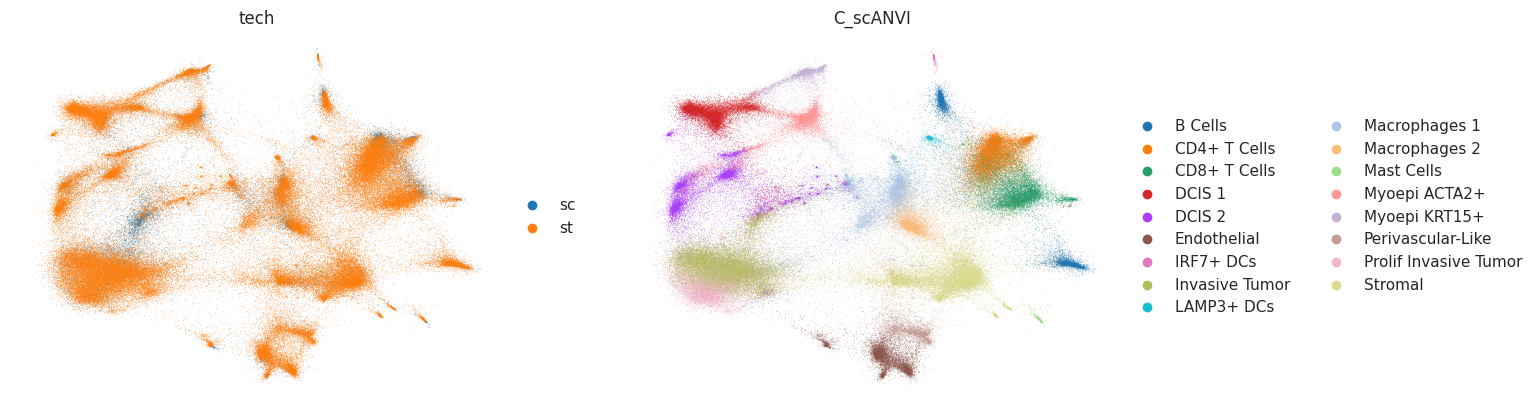

In [16]:
SCVI_MDE_KEY = "X_scVI_mde"
sc.pl.embedding(
    sc.read_h5ad(f"{config.output_dir}/scVI_output/UCS_10X/adata.h5ad"),
    basis=SCVI_MDE_KEY,
    color=["tech", "C_scANVI"],
    frameon=False,
    ncols=2,
)

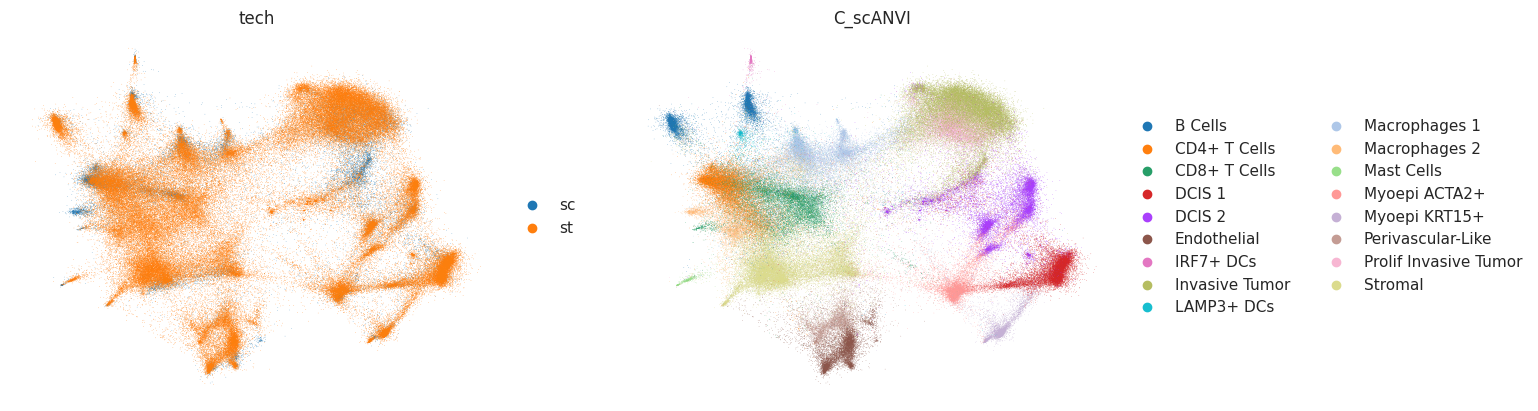

In [17]:
sc.pl.embedding(
    sc.read_h5ad(f"{config.output_dir}/scVI_output/Cell_10X/adata.h5ad"), 
    basis=SCVI_MDE_KEY,
    color=["tech", "C_scANVI"],
    frameon=False,
    ncols=2,
)

## Spatail Neighborhood

  0%|          | 0/1000 [00:00<?, ?/s]

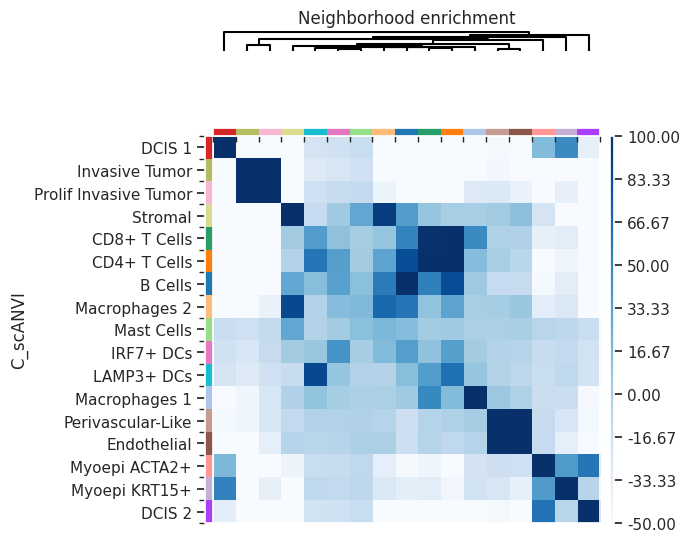

In [18]:
import squidpy as sq
sq.gr.spatial_neighbors(ad_st_dict["UCS_10X"])
sq.gr.nhood_enrichment(ad_st_dict["UCS_10X"], cluster_key="C_scANVI")
sq.pl.nhood_enrichment(ad_st_dict["UCS_10X"], cluster_key="C_scANVI",method="single", cmap="Blues",figsize=(5,5), vmin=-50, vmax=100)

## Spatail Gene

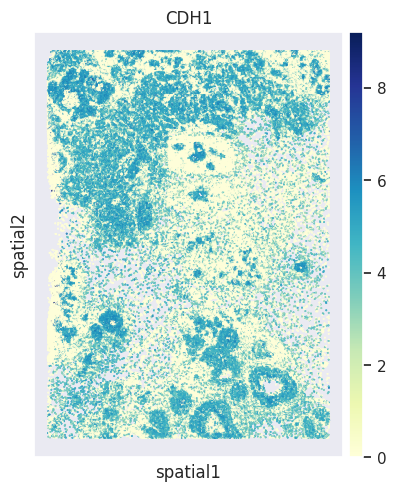

In [20]:
sq.gr.spatial_neighbors(ad_st_dict["Cell_10X"])
sq.gr.spatial_autocorr(ad_st_dict["Cell_10X"], mode="moran")
sq.pl.spatial_scatter(
    ad_st_dict["Cell_10X"],
    shape=None,
    color=["CDH1"],
    size=0.5,
    cmap = "YlGnBu"
)

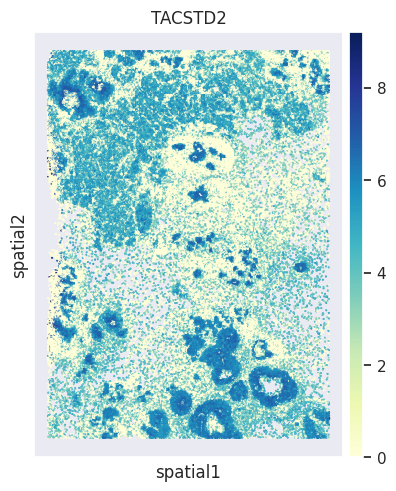

In [21]:
sq.gr.spatial_neighbors(ad_st_dict["Cell_10X"])
sq.gr.spatial_autocorr(ad_st_dict["Cell_10X"], mode="moran")
sq.pl.spatial_scatter(
    ad_st_dict["Cell_10X"],
    shape=None,
    color=["TACSTD2"],
    size=0.5,
    cmap = "YlGnBu"
)

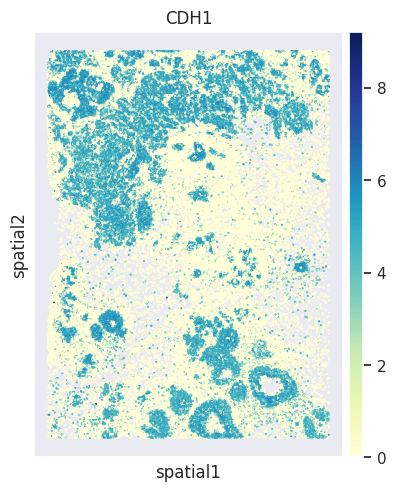

In [22]:
sq.gr.spatial_neighbors(ad_st_dict["UCS_10X"])
sq.gr.spatial_autocorr(ad_st_dict["UCS_10X"], mode="moran")
sq.pl.spatial_scatter(
ad_st_dict["UCS_10X"],
shape = None,
color = ["CDH1"],
size = 0.5,
cmap = "YlGnBu"
)

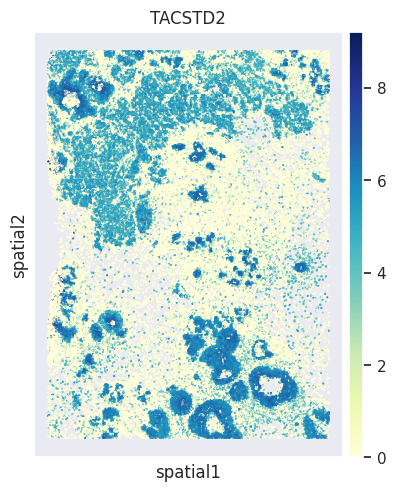

In [23]:
sq.gr.spatial_neighbors(ad_st_dict["UCS_10X"])
sq.gr.spatial_autocorr(ad_st_dict["UCS_10X"], mode="moran")
sq.pl.spatial_scatter(
    ad_st_dict["UCS_10X"],
    shape=None,
    color=["TACSTD2"],
    size=0.5,
    cmap = "YlGnBu"
)

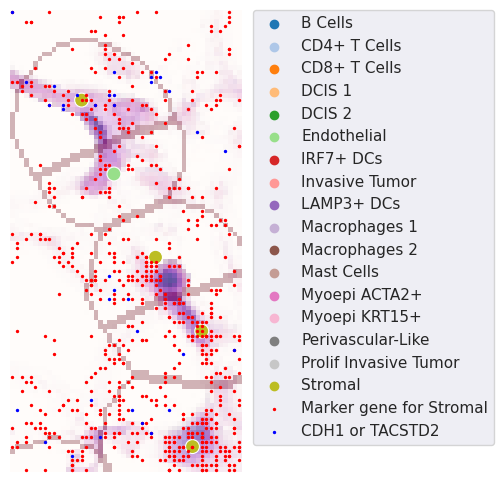

In [24]:
# Why this happen?
fig, ax = plt.subplots(figsize=(6, 6))
# Sorted by cell type
x_min, x_max, y_min, y_max = 4625, 4725, 4610, 4660
ad = ad_st_dict["Cell_10X"]
cell_roi = ad[(ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (ad.obsm["spatial"][:, 1] < y_max)]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=100 , palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
np.random.seed(5)
pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
for i in range(0, gene_map.shape[2]):
    if pos_gene[i] > 0:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="red")
# pos_gene = pos_gene_df.loc['Malignant'].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
gene_plot = ["CDH1", "TACSTD2"]
for i in range(0, gene_map.shape[2]):
    if gene_names[i] in gene_plot:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
# Legend outside
ax.scatter(0, 0, s=2, c="red", label="Marker gene for Stromal")
ax.scatter(0, 0, s=2, c="blue", label="CDH1 or TACSTD2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_axis_off()
ax.imshow(boundary_dict['Cell_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)

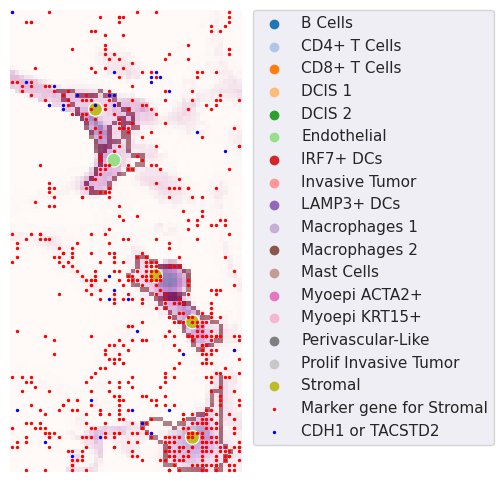

In [25]:
ax.imshow(boundary_dict['Cell_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)
fig, ax = plt.subplots(figsize=(6, 6))
# Sorted by cell type
x_min, x_max, y_min, y_max = 4625, 4725, 4610, 4660
ad = ad_st_dict["UCS_10X"]
cell_roi = ad[
    (ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (
                ad.obsm["spatial"][:, 1] < y_max)]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=100, palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
np.random.seed(5)
pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
for i in range(0, gene_map.shape[2]):
    if pos_gene[i] > 0:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1],
                   np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="red")
gene_plot = ["CDH1", "TACSTD2"]
for i in range(0, gene_map.shape[2]):
    if gene_names[i] in gene_plot:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1],
                   np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
# Legend outside
ax.scatter(0, 0, s=2, c="red", label="Marker gene for Stromal")
ax.scatter(0, 0, s=2, c="blue", label="CDH1 or TACSTD2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.set_axis_off()
ax.imshow(boundary_dict['UCS_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.5)

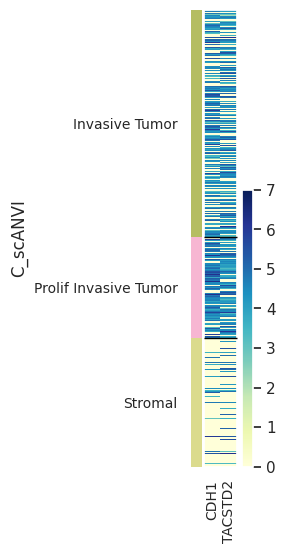

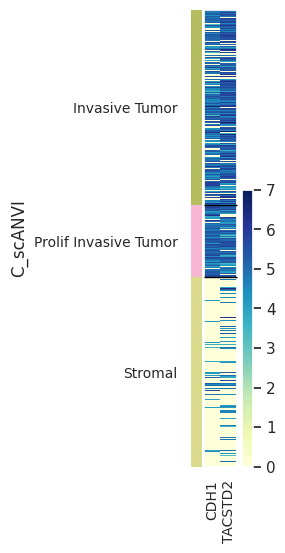

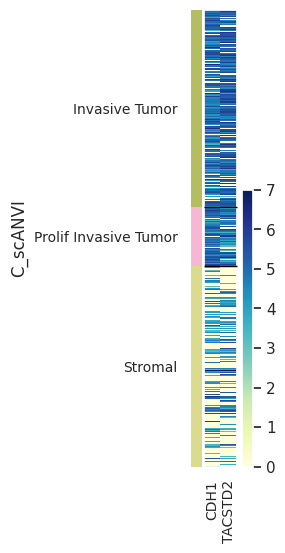

In [26]:
adata = ad_sc.copy()
adata.X = adata.layers["counts"]
gene_list = ["CDH1", "TACSTD2"] # ad_st_dict["USC SBG 10X"].var.index
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["Stromal", "Invasive Tumor", "Prolif Invasive Tumor"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='YlGnBu', show_gene_labels=True, vmax=7)

adata = ad_st_dict["UCS_10X"].copy()
adata.X = adata.layers["counts"]
gene_list = ["CDH1", "TACSTD2"] # ad_st_dict["USC SBG 10X"].var.index
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["Stromal","Invasive Tumor", "Prolif Invasive Tumor"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='YlGnBu', show_gene_labels=True, vmax=7)

# adata = ad_st_dict["BIDCell"].copy()
# adata.X = adata.layers["counts"]
# gene_list = ["CDH1", "TACSTD2"] # ad_st_dict["USC SBG 10X"].var.index
# # Only show invasive tumor and Prolif Invasive Tumor
# adata = adata[adata.obs["C_scANVI"].isin(["Stromal","Invasive Tumor", "Prolif Invasive Tumor"])]
# sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='RdYlBu_r', show_gene_labels=True, vmax=7)

adata = ad_st_dict["Cell_10X"].copy()
adata.X = adata.layers["counts"]
gene_list = ["CDH1", "TACSTD2"] # ad_st_dict["USC SBG 10X"].var.index
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["Stromal","Invasive Tumor", "Prolif Invasive Tumor"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='YlGnBu', show_gene_labels=True, vmax=7)

## Marker gene analysis

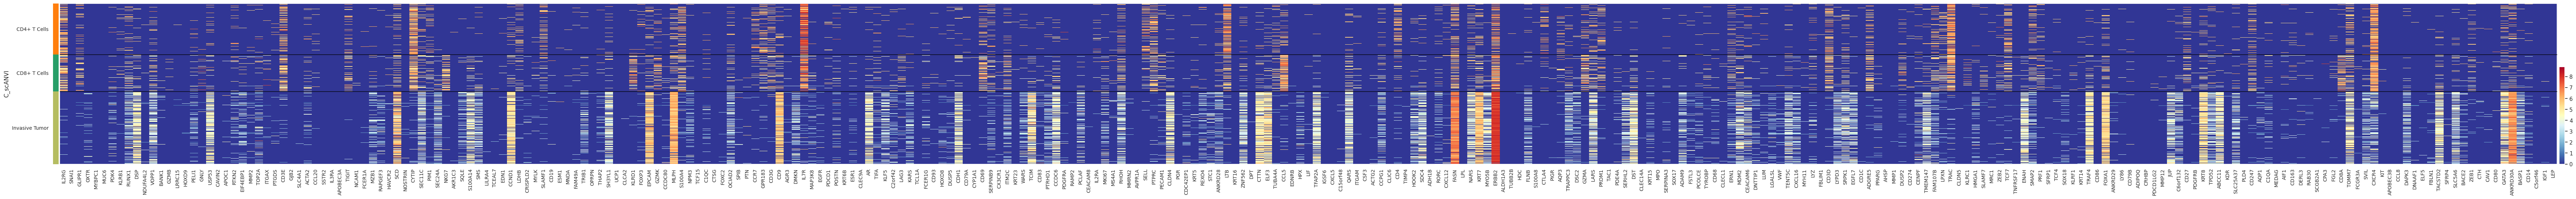

In [27]:
adata = ad_sc.copy()
adata.X = adata.layers["counts"]
gene_list = ad_st_dict["UCS_10X"].var.index # ["ERBB2", "MKI67"]
# Only show invasive tumor and Prolif Invasive Tumor
adata = adata[adata.obs["C_scANVI"].isin(["CD4+ T Cells", "CD8+ T Cells", "Invasive Tumor", "T Cell & Tumor Hybrid", "Stromal & T Cell Hybrid"])]
sc.pl.heatmap(adata,gene_list, groupby='C_scANVI', cmap='RdYlBu_r', show_gene_labels=True)

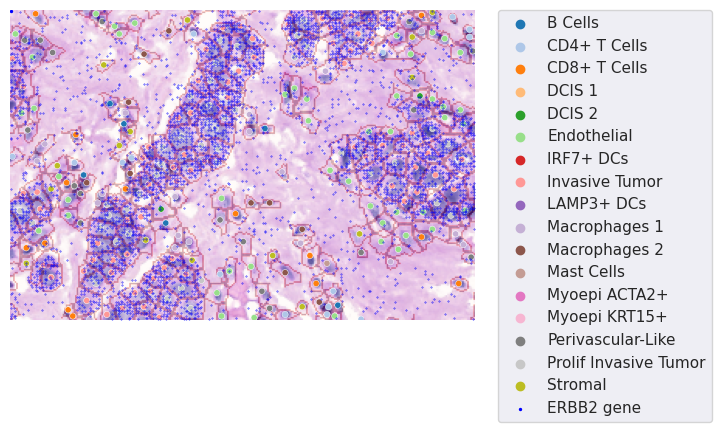

In [28]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))
# Sorted by cell type
x_min, x_max, y_min, y_max = 1600, 1800, 2500, 2800
ad = ad_st_dict["UCS_10X"]
cell_roi = ad[(ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (ad.obsm["spatial"][:, 1] < y_max)]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=20 , palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression


np.random.seed(5)
# pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="red")
# pos_gene = pos_gene_df.loc['Malignant'].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
gene_plot = ["ERBB2"]
for i in range(0, gene_map.shape[2]):
    if gene_names[i] in gene_plot:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=0.1, c="blue")

# Legend outside
ax.scatter(0, 0, s=2, c="blue", label="ERBB2 gene")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=0.1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.set_axis_off()
ax.imshow(boundary_dict['UCS_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)

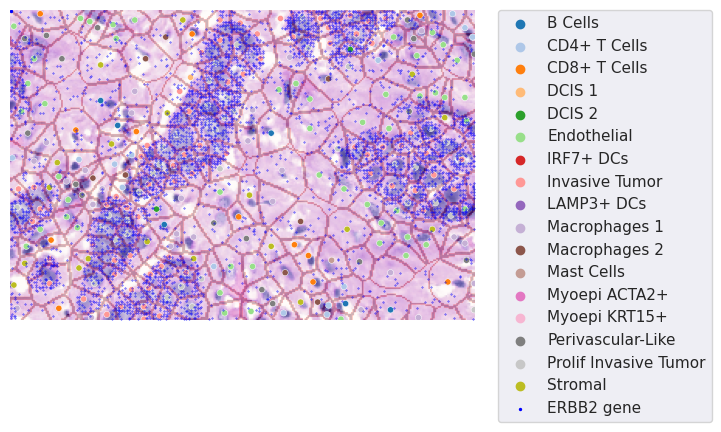

In [29]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))
# Sorted by cell type
x_min, x_max, y_min, y_max = 1600, 1800, 2500, 2800
ad = ad_st_dict["Cell_10X"]
cell_roi = ad[(ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (ad.obsm["spatial"][:, 1] < y_max)]
plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
# Minus the x_min and y_min
plot_df['center_x'] = plot_df['center_x'] - x_min
plot_df['center_y'] = plot_df['center_y'] - y_min
plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
# Category of cell type
plot_df['C_scANVI'] = pd.Categorical(
    plot_df['C_scANVI'],
    categories=ad.obs['C_scANVI'].cat.categories,
    ordered=True
)
sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                hue=plot_df['C_scANVI'], s=20 , palette='tab20')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# imshow he and boundary of BIDCell
ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
# Gene Expression
np.random.seed(5)
# pos_gene = pos_gene_df.loc["Myofibroblasts"].astype(bool) | pos_gene_df.loc["Fibroblasts"].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=0.1, c="red")
# pos_gene = pos_gene_df.loc['Malignant'].astype(bool)
# for i in range(0, gene_map.shape[2]):
#     if pos_gene[i] > 0:
#         ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=2, c="blue")
gene_plot = ["ERBB2"]
for i in range(0, gene_map.shape[2]):
    if gene_names[i] in gene_plot:
        ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=0.1, c="blue")
# Legend outside
ax.scatter(0, 0, s=2, c="blue", label="ERBB2 gene")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# for i in range(0, gene_map.shape[2]):
#     ax.scatter(np.where(gene_map[x_min:x_max, y_min:y_max, i])[1], np.where(gene_map[x_min:x_max, y_min:y_max, i])[0], s=0.1, c=np.random.rand(3, ))
# Nuclei
# ax.imshow(mask_dict["Nuclei_10X"][x_min:x_max, y_min:y_max], cmap='Greens', alpha=0.6)
# Image boundary
ax.set_axis_off()
ax.imshow(boundary_dict['Cell_10X'][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)

In [30]:
# Expression of TOP2A and celltype is Invasive Tumor / Prolif Invasive Tumor
gene = "ERBB2"
ad_ucs_it = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_ucs_pit = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
ad_10X_it = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_10X_pit = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
ad_10X_nuclei_it = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_10X_nuclei_pit = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
ad_bid_it = ad_st_dict["BIDCell"][ad_st_dict["BIDCell"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_bid_pit = ad_st_dict["BIDCell"][ad_st_dict["BIDCell"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
# Extract col TOP2A
gene_ucs_it = ad_ucs_it[:, ad_ucs_it.var.index == gene].layers["counts"].toarray().flatten()
gene_ucs_pit = ad_ucs_pit[:, ad_ucs_pit.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_it = ad_10X_it[:, ad_10X_it.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_pit = ad_10X_pit[:, ad_10X_pit.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_nuclei_it = ad_10X_nuclei_it[:, ad_10X_nuclei_it.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_nuclei_pit = ad_10X_nuclei_pit[:, ad_10X_nuclei_pit.var.index == gene].layers["counts"].toarray().flatten()
gene_bid_it = ad_bid_it[:, ad_bid_it.var.index == gene].layers["counts"].toarray().flatten()
gene_bid_pit = ad_bid_pit[:, ad_bid_pit.var.index == gene].layers["counts"].toarray().flatten()

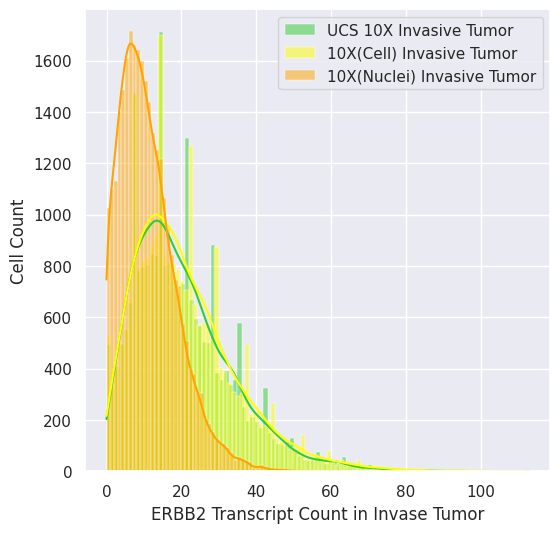

In [31]:
# Plot
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(gene_ucs_it, color="limegreen", label="UCS 10X Invasive Tumor", kde=True)
# sns.histplot(gene_ucs_pit, color="green", label=f"UCS", kde=True, binwidth=1)
sns.histplot(gene_10X_it, color="yellow", label="10X(Cell) Invasive Tumor", kde=True)
# sns.histplot(gene_10X_pit, color="yellow", label=f"Cell 10X Prolif Invasive Tumor", kde=True, binwidth=1)
sns.histplot(gene_10X_nuclei_it, color="orange", label=f"10X(Nuclei) Invasive Tumor", kde=True, binwidth=1)
# sns.histplot(gene_10X_nuclei_pit, color="orange", label=f"Nuclei", kde=True, binwidth=1)
# Label
plt.xlabel(f"{gene} Transcript Count in Invase Tumor")
plt.ylabel("Cell Count")
plt.legend()

In [32]:
# Expression of TOP2A and celltype is Invasive Tumor / Prolif Invasive Tumor
gene = "CDH1"
ad_ucs_it = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_ucs_pit = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
ad_10X_it = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_10X_pit = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
ad_10X_nuclei_it = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
ad_10X_nuclei_pit = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
# Extract col TOP2A
gene_ucs_it = ad_ucs_it[:, ad_ucs_it.var.index == gene].layers["counts"].toarray().flatten()
gene_ucs_pit = ad_ucs_pit[:, ad_ucs_pit.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_it = ad_10X_it[:, ad_10X_it.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_pit = ad_10X_pit[:, ad_10X_pit.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_nuclei_it = ad_10X_nuclei_it[:, ad_10X_nuclei_it.var.index == gene].layers["counts"].toarray().flatten()
gene_10X_nuclei_pit = ad_10X_nuclei_pit[:, ad_10X_nuclei_pit.var.index == gene].layers["counts"].toarray().flatten()

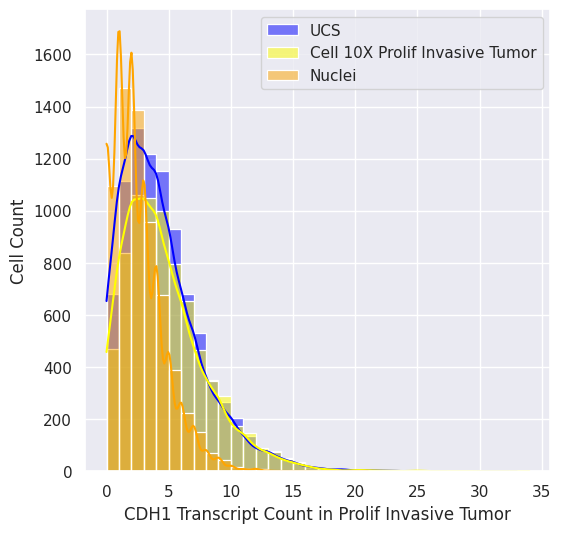

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(6, 6))
# sns.histplot(gene_ucs_it, color="green", label="USC SBG 10X Invasive Tumor", kde=True)
sns.histplot(gene_ucs_pit, color="blue", label=f"UCS", kde=True, binwidth=1)
# sns.histplot(gene_10X_it, color="yellow", label="Cell 10X Invasive Tumor", kde=True)
sns.histplot(gene_10X_pit, color="yellow", label=f"Cell 10X Prolif Invasive Tumor", kde=True, binwidth=1)
# sns.histplot(gene_10X_nuclei_it, color="orange", label=f"Nuclei 10X Invasive Tumor", kde=True, binwidth=1)
sns.histplot(gene_10X_nuclei_pit, color="orange", label=f"Nuclei", kde=True, binwidth=1)
# Label
plt.xlabel(f"{gene} Transcript Count in Prolif Invasive Tumor")
plt.ylabel("Cell Count")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


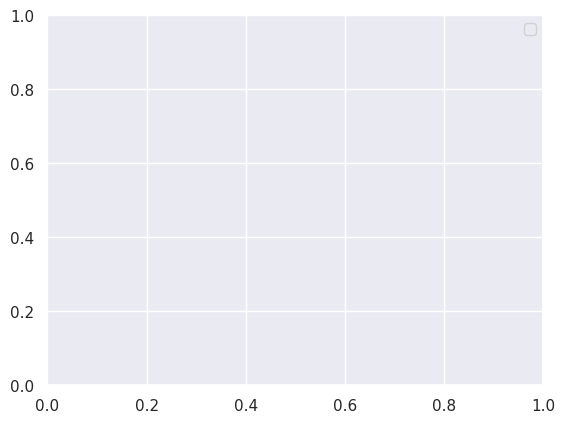

In [34]:
plt.legend()
# Boxplot
gene = "ERBB2"
box_ucs = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
box_ucs = box_ucs[:, box_ucs.var.index == gene].layers["counts"].toarray().flatten()

box_10X = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
box_10X = box_10X[:, box_10X.var.index == gene].layers["counts"].toarray().flatten()

box_10X_nuclei = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Invasive Tumor"])]
box_10X_nuclei = box_10X_nuclei[:, box_10X_nuclei.var.index == gene].layers["counts"].toarray().flatten()

box_bid = ad_st_dict["BIDCell"][ad_st_dict["BIDCell"].obs["C_scANVI"].isin(["Invasive Tumor"])]
box_bid = box_bid[:, box_bid.var.index == gene].layers["counts"].toarray().flatten()

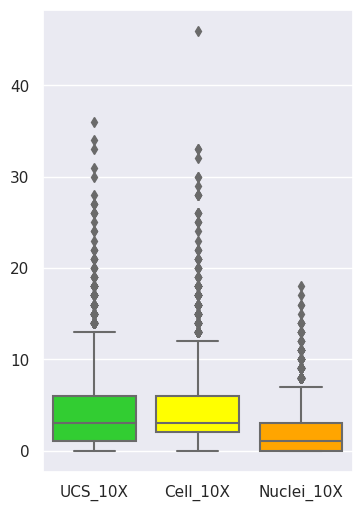

In [63]:
max_len = max(len(box_ucs), len(box_10X), len(box_10X_nuclei), len(box_bid))
# Box plot number of total transcripts per cell
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(4, 6))
df_total = pd.DataFrame(index=range(max_len))
df_dict_ = {
    "UCS_10X": pd.Series(box_ucs),
    "Cell_10X": pd.Series(box_10X),
    "Nuclei_10X": pd.Series(box_10X_nuclei),
}
for method in df_dict_.keys():
    total = df_dict_[method]
    # Reindex from 0
    total.index = range(len(total))
    df_total[method] = total
sns.boxplot(data=df_total, ax = ax, palette="Set3")
mybox = ax.patches[0] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('limegreen')
mybox = ax.patches[1] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('yellow')
mybox = ax.patches[2] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('orange')

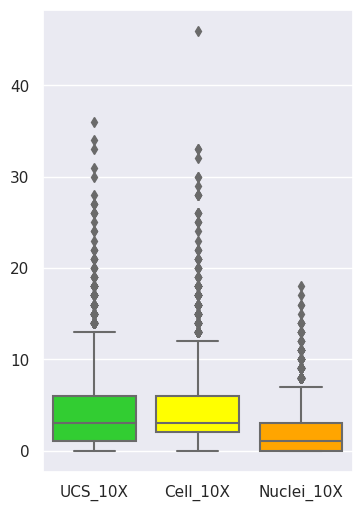

In [62]:
# Boxplot
gene = "TACSTD2"
box_ucs = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
box_ucs = box_ucs[:, box_ucs.var.index == gene].layers["counts"].toarray().flatten()

box_10X = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
box_10X = box_10X[:, box_10X.var.index == gene].layers["counts"].toarray().flatten()

box_10X_nuclei = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
box_10X_nuclei = box_10X_nuclei[:, box_10X_nuclei.var.index == gene].layers["counts"].toarray().flatten()

box_bid = ad_st_dict["BIDCell"][ad_st_dict["BIDCell"].obs["C_scANVI"].isin(["Prolif Invasive Tumor"])]
box_bid = box_bid[:, box_bid.var.index == gene].layers["counts"].toarray().flatten()
max_len = max(len(box_ucs), len(box_10X), len(box_10X_nuclei), len(box_bid))
# Box plot number of total transcripts per cell
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(4, 6))
df_total = pd.DataFrame(index=range(max_len))
df_dict_ = {
    "UCS_10X": pd.Series(box_ucs),
    "Cell_10X": pd.Series(box_10X),
    "Nuclei_10X": pd.Series(box_10X_nuclei),
}
for method in df_dict_.keys():
    total = df_dict_[method]
    # Reindex from 0
    total.index = range(len(total))
    df_total[method] = total
sns.boxplot(data=df_total, ax = ax, palette="Set3")
mybox = ax.patches[0] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('limegreen')
mybox = ax.patches[1] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('yellow')
mybox = ax.patches[2] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('orange')

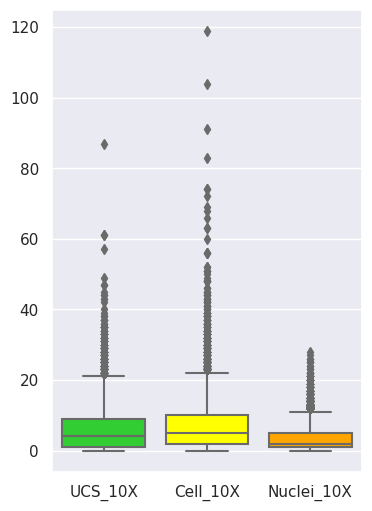

In [64]:
# Boxplot
gene = "LYZ"
box_ucs = ad_st_dict["UCS_10X"][ad_st_dict["UCS_10X"].obs["C_scANVI"].isin(["Macrophages 1"])]
box_ucs = box_ucs[:, box_ucs.var.index == gene].layers["counts"].toarray().flatten()

box_10X = ad_st_dict["Cell_10X"][ad_st_dict["Cell_10X"].obs["C_scANVI"].isin(["Macrophages 1"])]
box_10X = box_10X[:, box_10X.var.index == gene].layers["counts"].toarray().flatten()

box_10X_nuclei = ad_st_dict["Nuclei_10X"][ad_st_dict["Nuclei_10X"].obs["C_scANVI"].isin(["Macrophages 1"])]
box_10X_nuclei = box_10X_nuclei[:, box_10X_nuclei.var.index == gene].layers["counts"].toarray().flatten()

box_bid = ad_st_dict["BIDCell"][ad_st_dict["BIDCell"].obs["C_scANVI"].isin(["B Cells"])]
box_bid = box_bid[:, box_bid.var.index == gene].layers["counts"].toarray().flatten()
max_len = max(len(box_ucs), len(box_10X), len(box_10X_nuclei), len(box_bid))
# Box plot number of total transcripts per cell
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(figsize=(4, 6))
df_total = pd.DataFrame(index=range(max_len))
df_dict_ = {
    "UCS_10X": pd.Series(box_ucs),
    "Cell_10X": pd.Series(box_10X),
    "Nuclei_10X": pd.Series(box_10X_nuclei),
}
for method in df_dict_.keys():
    total = df_dict_[method]
    # Reindex from 0
    total.index = range(len(total))
    df_total[method] = total
sns.boxplot(data=df_total, ax = ax, palette="Set3")
mybox = ax.patches[0] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('limegreen')
mybox = ax.patches[1] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('yellow')
mybox = ax.patches[2] # `patches` instead of `artists`
# Change the appearance of that box
mybox.set_facecolor('orange')

## Compare average gene expression with single cell data

In [65]:
all_avg_df = {}
for method in ad_st_dict.keys():
    avg_df = pd.DataFrame(index=np.unique(ad_st_dict[method].obs["C_scANVI"]), columns=ad_st_dict[method].var.index)
    ad_temp= ad_st_dict[method].copy()
    # Scale
    sc.pp.scale(ad_temp, max_value=10)
    for cell_type in np.unique(ad_temp.obs["C_scANVI"]):
        ad = ad_temp[ad_temp.obs["C_scANVI"] == cell_type]
        avg_df.loc[cell_type] = ad.X.mean(axis=0)
    all_avg_df[method] = avg_df

In [66]:
avg_sc = pd.DataFrame(index=np.unique(ad_sc.obs["C_scANVI"]), columns = ad_sc.var.index)
ad_temp = ad_sc.copy()
# Scale
sc.pp.scale(ad_temp, max_value=10)
for cell_type in np.unique(ad_temp.obs["C_scANVI"]):
    ad = ad_temp[ad_temp.obs["C_scANVI"] == cell_type]
    avg_sc.loc[cell_type] = ad.X.mean(axis=0)

In [67]:
# Same column order
for method in all_avg_df.keys():
    all_avg_df[method] = all_avg_df[method][avg_sc.columns]

In [68]:
# Pearson correlation for each method and each Celltype
from scipy.stats import pearsonr

all_corr_df = {}
for method in all_avg_df.keys():
    corr_df = pd.DataFrame(index=np.unique(ad_sc.obs["C_scANVI"]), columns=all_avg_df[method].index)
    for cell_type in np.unique(ad_sc.obs["C_scANVI"]):
        for method_cell_type in all_avg_df[method].index:
            corr_df.loc[cell_type, method_cell_type] = pearsonr(all_avg_df[method].loc[method_cell_type], avg_sc.loc[cell_type])[0]
    all_corr_df[method] = corr_df
    # Convert to float
    all_corr_df[method] = all_corr_df[method].astype(float)

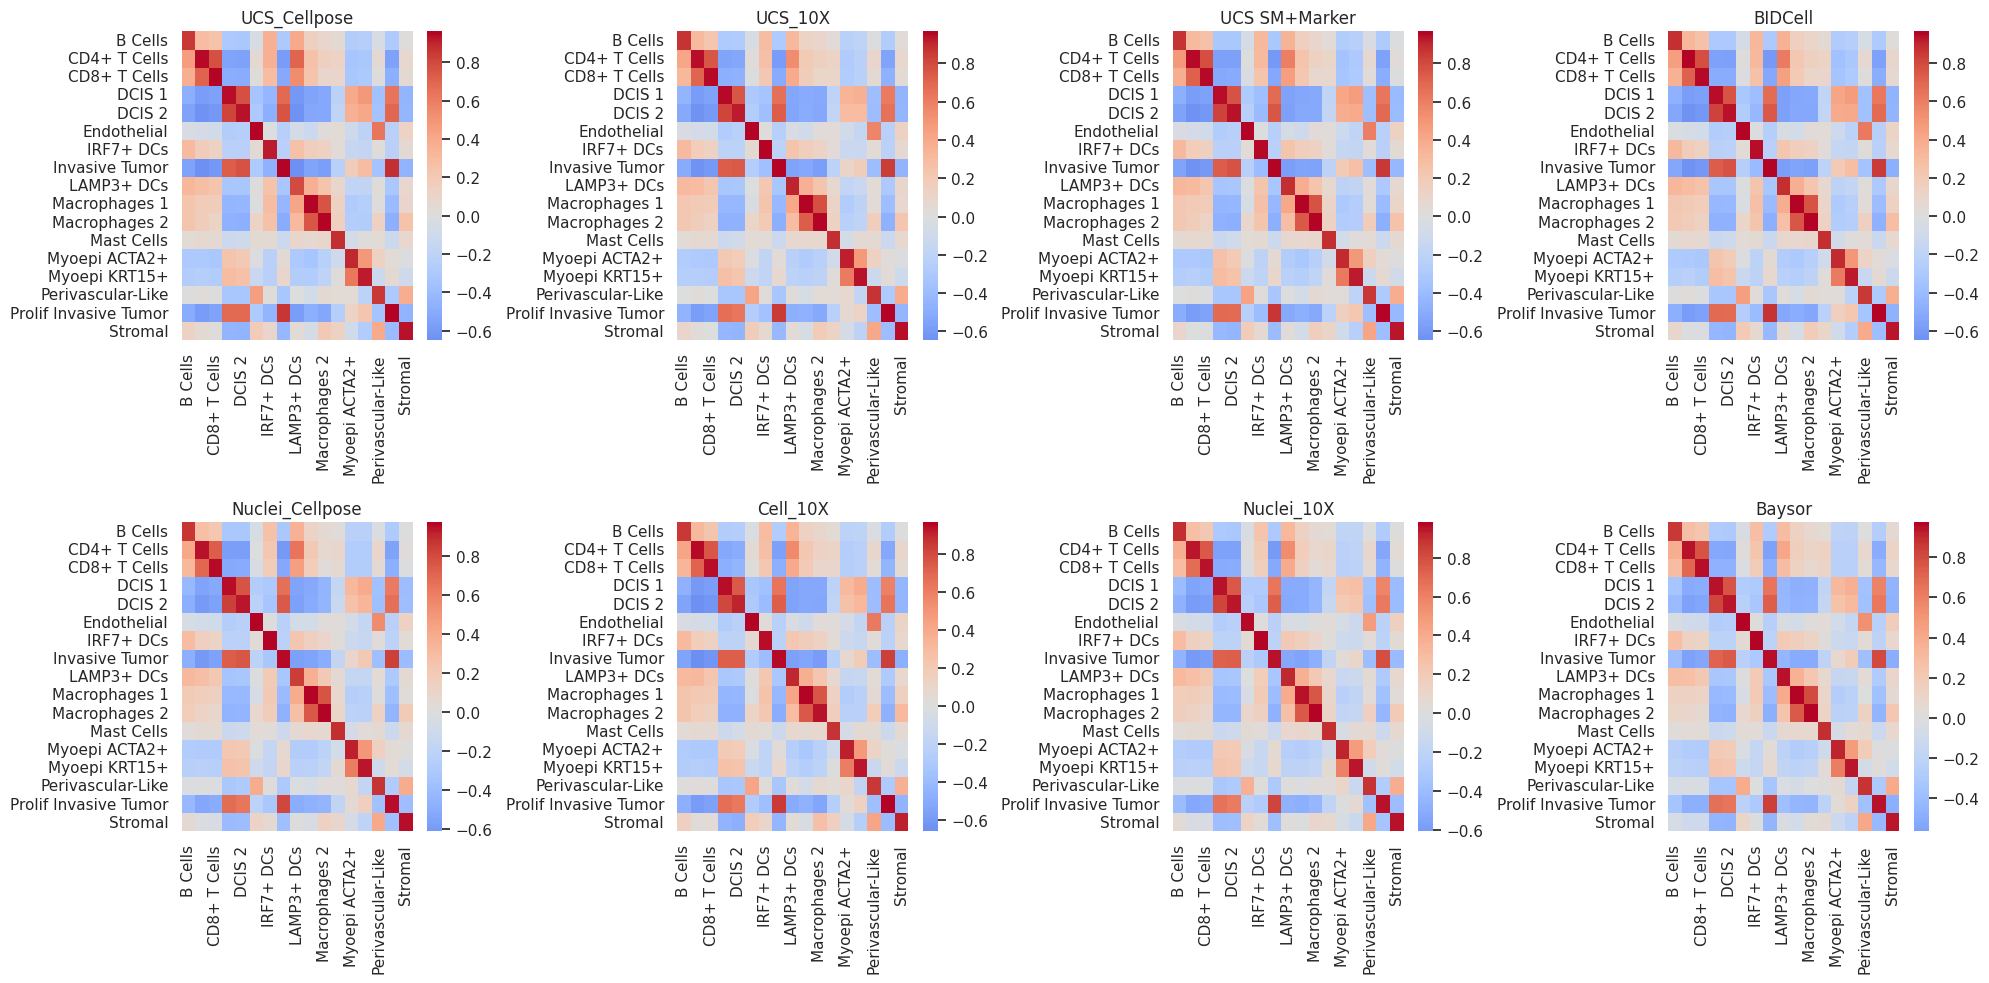

In [69]:
# Plot
import seaborn as sns
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
# Flatten
ax = ax.flatten()
for i, method in enumerate(all_corr_df.keys()):
    sns.heatmap(all_corr_df[method], ax=ax[i], cmap="coolwarm", center=0)
    ax[i].set_title(f"{method}")
plt.tight_layout()

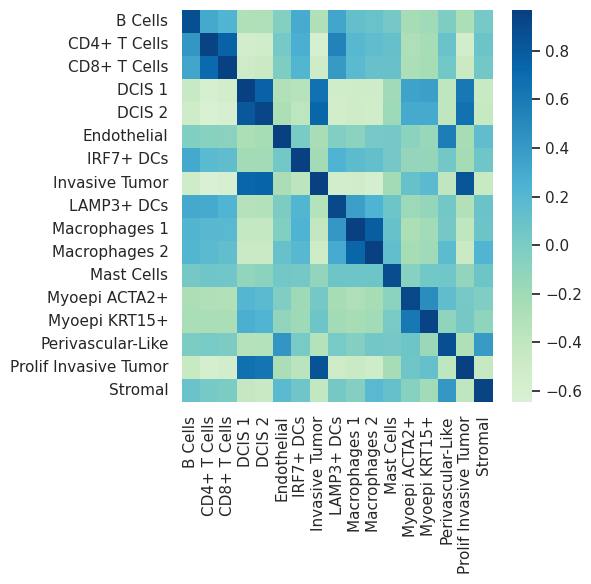

In [70]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(all_corr_df["UCS_10X"], cmap="GnBu", center=0)
plt.tight_layout()

In [71]:
# Avg pearson correlation with the same cell type
corr_df = pd.DataFrame(index=np.unique(ad_sc.obs["C_scANVI"]), columns=all_avg_df.keys())
for cell_type in np.unique(ad_sc.obs["C_scANVI"]):
    for method in all_avg_df.keys():
        corr_df.loc[cell_type, method] = pearsonr(all_avg_df[method].loc[cell_type], avg_sc.loc[cell_type])[0]

In [72]:
# Avg for all cell for a method
corr_each_method = pd.DataFrame(index=all_avg_df.keys(), columns=["Avg"])
for method in all_avg_df.keys():
    corr_each_method.loc[method, "Avg"] = corr_df[method].mean()

In [73]:
# Get avg transcripts per cell
# Add new column
corr_each_method["Avg Transcripts"] = 0
for method in all_avg_df.keys():
    total = df_dict[method].iloc[:, :313].sum(axis=1)
    corr_each_method.loc[method, "Avg Transcripts"] = total.mean()

Text(0, 0.5, 'Avg Pearson correlation')

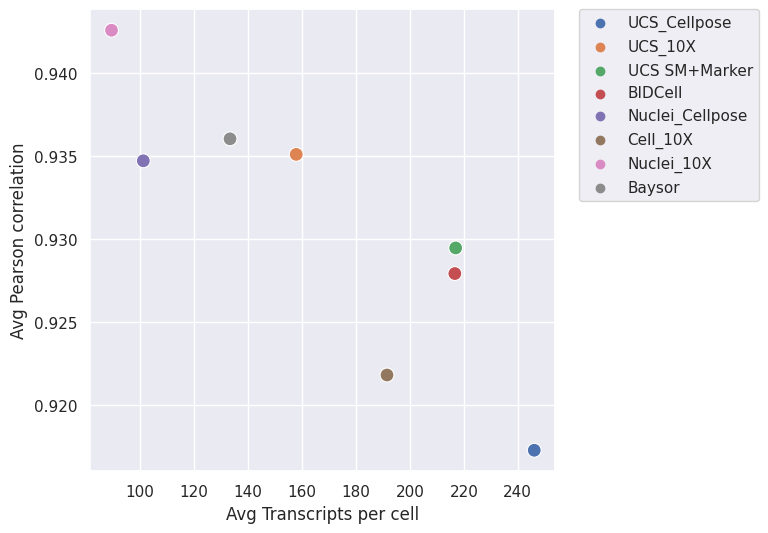

In [74]:
# Plot: X: Avg transcripts per cell, Y: Avg Pearson correlation, Label: Method
# Legend ouside
# Predefine color: UCS_10X: Orange, Nuclei_10X: pink, Cell_10X: brown, BIDCell: red, Baysor: grey, Nuclei_Cellpose: purple, UCS_Cellpose: Blue
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=corr_each_method, x="Avg Transcripts", y="Avg", hue=corr_each_method.index, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Avg Transcripts per cell")
plt.ylabel("Avg Pearson correlation")

In [75]:
# Celltype proportion for UCS_10X and Single cell data
method = "Cell_10X"
prop_ucs = pd.DataFrame(index=np.unique(ad_sc.obs["C_scANVI"]), columns=[method, "Single Cell"])
for cell_type in np.unique(ad_sc.obs["C_scANVI"]):
    prop_ucs.loc[cell_type, method] = len(ad_st_dict[method][ad_st_dict[method].obs["C_scANVI"] == cell_type]) / len(ad_st_dict[method])
    prop_ucs.loc[cell_type, "Single Cell"] = len(ad_sc[ad_sc.obs["C_scANVI"] == cell_type]) / len(ad_sc)

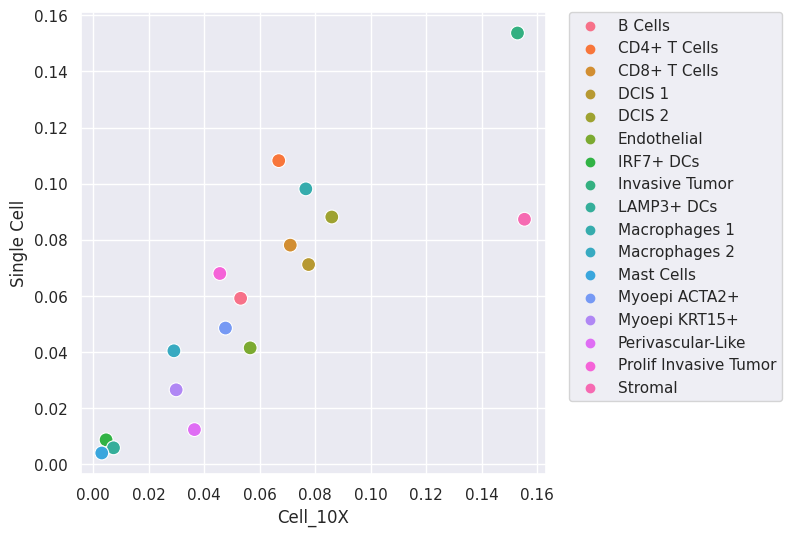

In [76]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=prop_ucs, x=method, y="Single Cell", hue=prop_ucs.index, s=100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Other Visualize

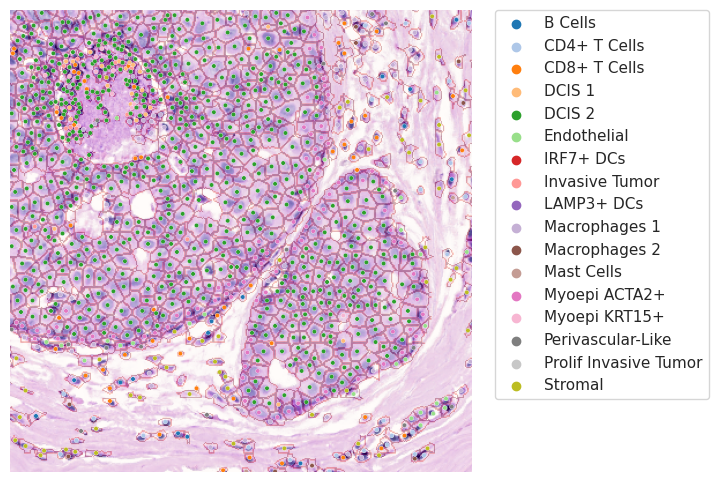

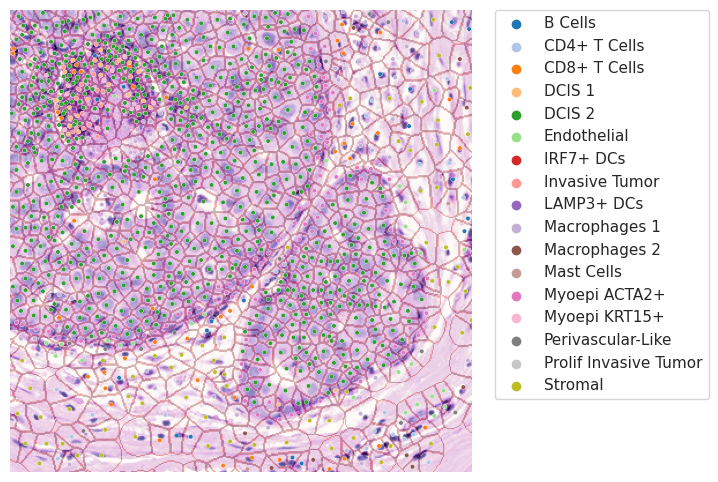

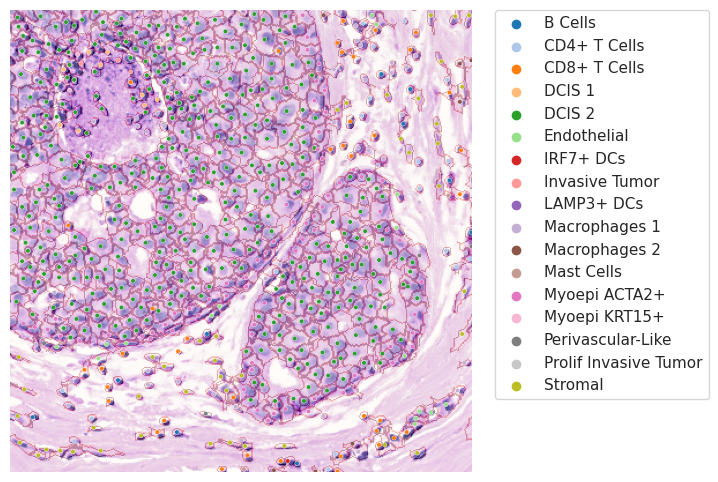

In [80]:
import numpy as np
# Plot all the cell and their cell type (by color) on the spatial map
# Small point
import matplotlib.pyplot as plt
import seaborn as sns

for method in ["UCS_10X", "Cell_10X", "BIDCell"]:
    fig, ax = plt.subplots(figsize=(6, 6))
    # Sorted by cell type
    x_min, x_max, y_min, y_max = 1200, 1600, 5200, 5600
    ad = ad_st_dict[method]
    cell_roi = ad[(ad.obsm["spatial"][:, 0] > x_min) & (ad.obsm["spatial"][:, 0] < x_max) & (ad.obsm["spatial"][:, 1] > y_min) & (ad.obsm["spatial"][:, 1] < y_max)]
    plot_df = pd.DataFrame(cell_roi.obsm['spatial'], columns=['center_x', 'center_y'])
    # Minus the x_min and y_min
    plot_df['center_x'] = plot_df['center_x'] - x_min
    plot_df['center_y'] = plot_df['center_y'] - y_min
    plot_df['C_scANVI'] = cell_roi.obs['C_scANVI'].values
    # Category of cell type
    plot_df['C_scANVI'] = pd.Categorical(
        plot_df['C_scANVI'],
        categories=ad.obs['C_scANVI'].cat.categories,
        ordered=True
    )
    sns.scatterplot(x=plot_df['center_y'], y=plot_df['center_x'],
                    hue=plot_df['C_scANVI'], s=10, palette='tab20')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # imshow he and boundary of BIDCell
    ax.imshow(he[:, x_min:x_max, y_min:y_max].transpose(1, 2, 0), aspect='auto')
    ax.imshow(boundary_dict[method][x_min:x_max, y_min:y_max], cmap='Reds', alpha=0.3)
    ax.set_axis_off()